In [1]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

## Old Code

The old CSV, DATA10(old).csv, that was given to us was not properly formated. Below is the code that we used to read the data from the old CSV.

In [2]:
class Data:
    def __init__(self):
        self.path = r"DATA10(old).csv"  # We are group 10
        # Reads Length(cm), T1~5(s), T_average(s), G(m/s^2)
        read = np.loadtxt(self.path, usecols=range(1, 4), max_rows=8, delimiter=',')
        self.length = read[0]
        self.time = read[1:6]
        self.time_average = read[6]
        self.calculated_g = read[7]
        # Reads error of G
        read = np.genfromtxt(self.path, delimiter=",", usecols=range(1, 4), dtype=str, skip_header=8, max_rows=1)
        self.g_error = np.array([float(x.strip('%')) for x in read])
        
        # Second part of the csv

data_instance = Data()
print(data_instance.g_error)

[1.5 6.7 3.8]


## New Code

#### Below is the code that we used to read the data from the new CSV, pendulum_experiment_2.csv.

Linear module: ax + b
a and b from least squares: 2.1492495478963485 -0.08656175948493453
a and b from chi squares: 2.1959036841695236 -0.1064930175602221
Least-square's g: 8.54645575461064
Chi-square's g: 8.18715781731885
Degrees of freedom: 3
Chi squared: 309713.6377153784
Reduced chi-squared: 103237.87923845947


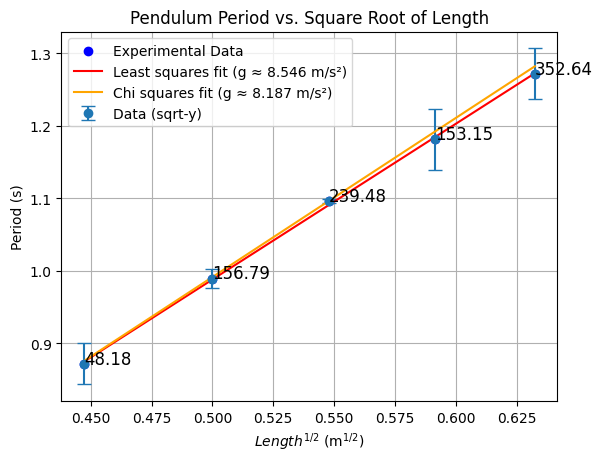

Residual plot for least squares fit


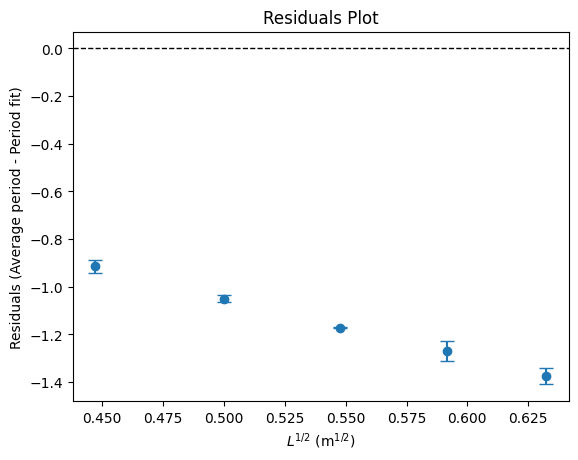

Residual plot for chi squares fit


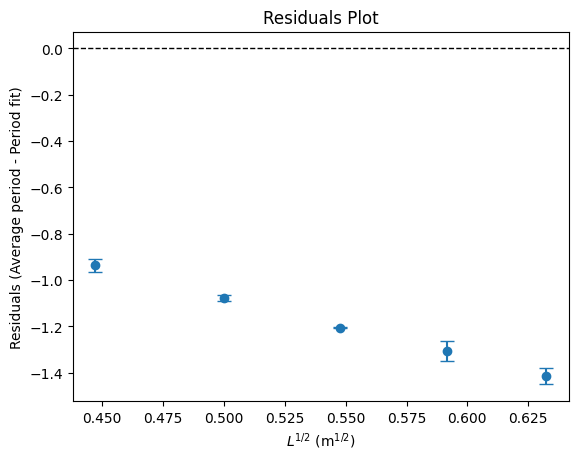

In [14]:
class Data:
    def __init__(self):
        self.path = r"pendulum_experiment_2.csv"  # new csv
        read = np.loadtxt(self.path, skiprows=1, usecols=range(0, 15), delimiter=',')
        # Format length(cm), period, average period, SD of period, theoretical period, measured error
        self.length = [row[0] for row in read]
        self.period = [row[6:11] for row in read] # This variable is not used
        self.average_period = [row[11] for row in read]
        self.period_stdev = [row[12] for row in read]
        self.theoretical_period = [row[13] for row in read] # This variable is not used
        self.period_uncertainty = [row[14] * 1/100 for row in read] # This is also known as measured error
        
        # Variables for fitting
        self.least_squares_popt, self.least_squares_pcov = curve_fit(self.linear_model, np.sqrt(self.length), self.average_period, absolute_sigma=False, method='lm') # Perform least-squares fitting unweighted
        self.chi_squares_popt, self.chi_squares_pcov = curve_fit(self.linear_model, np.sqrt(self.length), self.average_period,  sigma=self.period_uncertainty, absolute_sigma=True, method='lm') # Perform chi squares fitting
        self.g_least_squares_fit, self.g_least_squares_error = self.fit(self.least_squares_popt, self.least_squares_pcov) # Calculate g and its error with least squares
        self.g_chi_squares_fit, self.g_chi_squares_error = self.fit(self.chi_squares_popt, self.chi_squares_pcov) # Calculate g and its error with chi squares
        print("Linear module: ax + b")
        print("a and b from least squares:", *self.least_squares_popt)
        print("a and b from chi squares:", *self.chi_squares_popt)
        
    def linear_model(self, x, a, b):
        # Define the linear model as Period = a * sqrt(length) + b
        x = np.array(x)  # Ensure x is a NumPy array
        return a * x + b

    def fit(self, popt, pcov):
        # Perform fitting the data to the linear model
        a_fit, b_fit = popt
        sigma_a, sigma_b = np.sqrt(np.diag(pcov))
        # Calculate g and its error
        g_fit = (4 * np.pi**2) / (a_fit**2)
        g_error = (8 * np.pi**2 * sigma_a) / (a_fit**3)
        
        return g_fit, g_error
    
    def plot(self):
        plt.scatter(np.sqrt(self.length), self.average_period, label="Experimental Data", color="blue")
        # Label each point with [(least square - original data) / standard deviation]
        for i in range(len(self.length)):
            label = (self.linear_model(self.average_period[i], *self.least_squares_popt)-self.average_period[i])/self.period_stdev[i]
            label = "{:.2f}".format(label) # Format the label to 2 decimal places
            plt.text(np.sqrt(self.length[i]), self.average_period[i], label, fontsize=12, color="black")
            
        # Plots the error bars using the measured error form the CSV
        plt.errorbar(np.sqrt(self.length), self.average_period, yerr=self.period_uncertainty, fmt='o', label='Data (sqrt-y)', capsize=5)
        # Plots the least squares and chi squares linear model
        plt.plot(np.sqrt(self.length), self.linear_model(np.sqrt(self.length), *self.least_squares_popt), label=f"Least squares fit (g ≈ {self.g_least_squares_fit:.3f} m/s²)", color="red")
        plt.plot(np.sqrt(self.length), self.linear_model(np.sqrt(self.length), *self.chi_squares_popt), label=f"Chi squares fit (g ≈ {self.g_chi_squares_fit:.3f} m/s²)", color="orange")
        
        plt.xlabel(r"$Length^{1/2}$ (m$^{1/2}$)") # Labels X Axis represents the square root of length
        plt.ylabel("Period (s)") # Labels Y Axis represents the period
        plt.legend()
        plt.title("Pendulum Period vs. Square Root of Length") # Title of the plot
        plt.grid()
        plt.show()
    
    def plot_residual(self, popt):
        y_fit = self.linear_model(self.average_period, *popt)
        residuals = self.average_period - y_fit # Calculate residuals)
        
        plt.errorbar(np.sqrt(self.length), residuals, yerr=self.period_uncertainty, fmt='o', capsize=5) # Plot residuals
        plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Zero residual line
        plt.xlabel(r"$L^{1/2}$ (m$^{1/2}$)") # Labels X Axis represents the square root of length
        plt.ylabel("Residuals (Average period - Period fit)") # Labels Y Axis represents the residuals
        plt.title("Residuals Plot")
        plt.show()


        
data_instance = Data()

print("Least-square's g:", data_instance.g_least_squares_fit)
print("Chi-square's g:", data_instance.g_chi_squares_fit)

'''
y_fit = data_instance.linear_model(data_instance.average_period, *data_instance.chi_squares_popt)
residuals = data_instance.average_period - y_fit # Calculate residuals
chi2 = np.sum((residuals / data_instance.period_uncertainty)**2)
dof = len(data_instance.length) - 2  # we fit 2 parameters (A and B)
reduced_chi2 = chi2 / dof
print("Degrees of freedom:", dof)
print("Chi squared:", chi2)
print("Reduced chi-squared:", reduced_chi2)
'''

data_instance.plot()
print("Residual plot for least squares fit")
data_instance.plot_residual(data_instance.least_squares_popt)
print("Residual plot for chi squares fit")
data_instance.plot_residual(data_instance.chi_squares_popt)


### Debug Log:

#### Error 1
```
TypeError                                 Traceback (most recent call last)
Cell In[90], line 67
     62         plt.grid()
     63         plt.show()
---> 67 data_instance = Data()
     68 data_instance.plot()
     69 print(data_instance.g_least_squares_fit)

Cell In[90], line 16, in Data.__init__(self)
     14 self.least_squares_popt, self.least_squares_pcov = curve_fit(self.linear_model, np.sqrt(self.length), self.average_period, absolute_sigma=True, method='lm') # Perform least-squares fitting unweighted
     15 self.chi_squares_popt, self.chi_squares_pcov = curve_fit(self.linear_model, np.sqrt(self.length), self.average_period,  sigma=self.period_uncertainty, absolute_sigma=True, method='lm') # Perform chi squares fitting
---> 16 self.g_least_squares_fit, self.g_least_squares_error = self.fit(self.least_squares_popt, self.least_squares_pcov)
     17 self.g_chi_squares_fit, self.g_chi_squares_error = self.fit(self.chi_squares_popt, self.chi_squares_pcov)

Cell In[90], line 32, in Data.fit(self, popt, pcov)
     28 g_fit = (4 * np.pi**2) / (a_fit**2)
     29 g_error = (8 * np.pi**2 * sigma_a) / (a_fit**3)
---> 32 y_fit = self.linear_model(self.average_period, *popt)
     33 residuals = self.average_period - y_fit
     35 # Plot residuals

Cell In[90], line 21, in Data.linear_model(self, x, a, b)
     19 def linear_model(self, x, a, b):
     20     # Define the linear model as Period = a * sqrt(length) + b
---> 21     return a * x + b

TypeError: can't multiply sequence by non-int of type 'numpy.float64'
```
This error was caused by the fact that the `self.average_period` variable was a list of `np.float64()` instead of a numpy array. This was fixed by changing the variable to a numpy array. This can easily done with `x = np.array(x)`, converting list x into a numpy array. Down below is the example of the results before and after the fix.\
\
before: [np.float64(2.84), np.float64(1.37), np.float64(0.22), np.float64(4.19), np.float64(3.51)]\
After: [2.84 1.37 0.22 4.19 3.51]
#### Error 2
```
TypeError                                 Traceback (most recent call last)
Cell In[146], line 76
     73 print("Least squares's g:", data_instance.g_least_squares_fit)
     74 print("Chi squares's g:", data_instance.g_chi_squares_fit)
---> 76 data_instance.plot()
     77 print("Residual plot for least squares fit")
     78 data_instance.plot_residuals(data_instance.least_squares_popt)

Cell In[146], line 41, in Data.plot(self)
     39 # Label each point with [(least square - original data) / standard deviation]
     40 for i in range(len(self.length)):
---> 41     label = (self.linear_model(self.average_period[i], self.least_squares_popt)-self.average_period[i])/self.period_stdev[i]
     42     label = "{:.2f}".format(label) # Format the label to 2 decimal places
     43     plt.text(np.sqrt(self.length[i]), self.average_period[i], label, fontsize=12, color="black")

TypeError: Data.linear_model() missing 1 required positional argument: 'b'
```
This error was caused by the fact that the `self.linear_model` function was missing a second parameter. And while popt is a `tuple`, it is not unpacked. This was fixed by unpacking the tuple. This can be done by adding a `*` before the tuple. This `*` can also be used to unpack lists to store into different variables and printed out so there isn't a bracket ([]) that indicates the variables is a list. 

### Results:
```
Linear module: y = ax + b
a and b from least squares: 2.1492495478963485 -0.08656175948493453
a and b from chi squares: 2.1959036990309984 -0.10649302568551619
Least-square's g: 8.54645575461064
Chi-square's g: 8.187157706500477
```
![Pendulum Period vs. Square Root of Length](./pictures/Pendulum_Period_vs_Square_Root_of_Length.png)\
#### Residual plot for least squares fit
![Residual plot for least squares fit](./pictures/Residual_plot_for_least_squares_fit.png)\
#### Residual plot for chi squares fit
![Residual plot for chi squares fit](./pictures/Residual_plot_for_chi_squares_fit.png)

### Result Explanation:
We can clearly see that while the curve fit created from both least square and chi square are very similar, there are still differences between the two. Theoretically, chi square fit should be slightly more accurate than the least square fit. This is because the chi square fit takes into account the uncertainty of the data points. However, least square is more closer to the 9.8 $m/s^2$ of Earth's approximated gravitation acceleration. The residuals plot for both fits show that the residuals are not centered around 0, which is a bad sign. This means that the models are not a good fit for the data.





## Extra Code Using Manual Caluation for Fitting g with Chi Squares (By Adrian frfr)

### Step-by-Step Example: Linearizing the Pendulum Equation Using Logarithms and Performing a Linear Fit in Python

The small-angle pendulum formula is given by:

$$T = 2\pi \sqrt{\frac{L}{g}},$$

which can be rewritten in logarithmic form as:

$$\ln(T) = \ln(2\pi) + \tfrac{1}{2} \ln(L) - \tfrac{1}{2} \ln(g).$$

By defining:

$$Y = \ln(T), \quad X = \ln(L),$$

the relationship simplifies to a linear form:

$$Y = A + BX.$$

In the ideal theoretical model:
(B = 0.5),
(A = \ln(2\pi) - \tfrac{1}{2}\ln(g)).

After fitting parameters (A) and (B) from experimental data:
Verify if (B) is close to the theoretical value of (0.5).
If (B \approx 0.5), solve for (g) using the following derivation:

$$
A = \ln(2\pi) - \tfrac{1}{2}\ln(g) \
\Longrightarrow \ln(g) = 2\left[\ln(2\pi) - A\right] \
\Longrightarrow g = e^{2\ln(2\pi) - 2A} = (2\pi)^2 e^{-2(A - \ln(2\pi))}.
$$

A_fit, B_fit: 0.7597439953018562 0.5547018232970042
------------------------------
A_err, B_err: 0.05670780142221639 0.04685731775436895
g fit: 8.638821233625103
Log-Log Linear Fit (ln T vs. ln L)
A (intercept)      = 0.7597439953018562 ± 0.05670780142221639
B (slope)          = 0.5547018232970042 ± 0.04685731775436895   (theory expects ~ 0.5)
g (from A, if B~0.5) = 8.638821233625103 m/s²
χ² (log space)     = 0.19759520543396575
Degrees of freedom = 3
Reduced χ²         = 0.06586506847798858


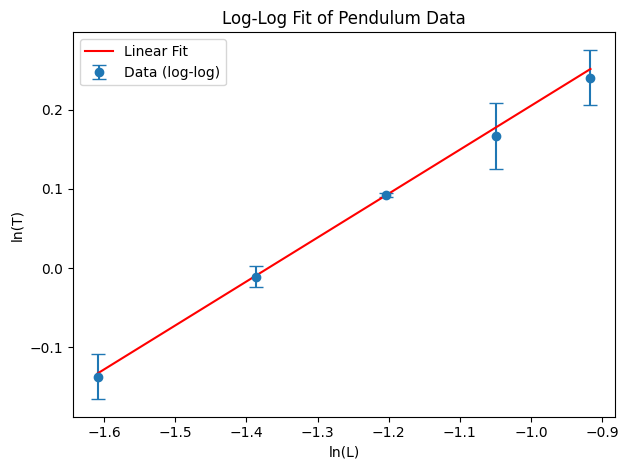

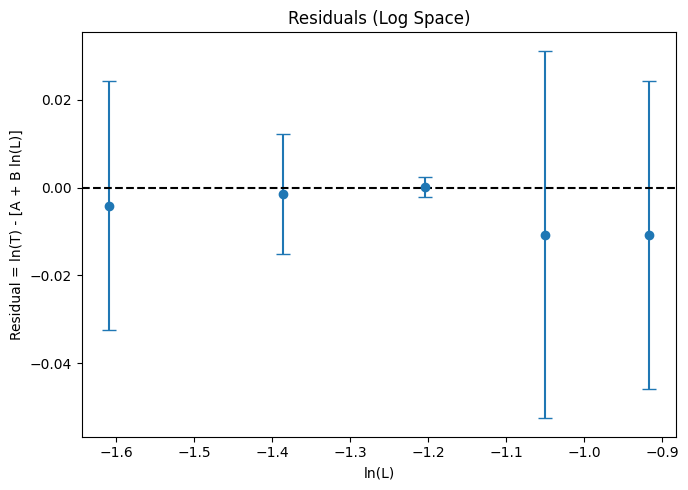

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

read = np.loadtxt('pendulum_experiment_2.csv', skiprows=1, usecols=range(0, 15), delimiter=',')
L = np.array([row[0] for row in read]) # Length measurements (m)
T = np.array([row[11] for row in read])  # Period measurements (s)

# Convert to Logarithms to make the relationship linear
X = np.log(L)  # ln(L)
Y = np.log(T)  # ln(T)

errors = np.array([row[14] * 1/100 for row in read])
T_err = errors*T 
Y_err = T_err/T # because we are dealing with logarithmic values

# Linear module for fitting
def linear_model(x, A, B):
    return A + B*x

popt, pcov = curve_fit(linear_model, X, Y, sigma=Y_err, absolute_sigma=True) # Perform fitting 
A_fit, B_fit = popt
A_err, B_err = np.sqrt(np.diag(pcov))
print("A_fit, B_fit:", *popt)
print('------------------------------')
print("A_err, B_err:", A_err, B_err)

# Doing algebra g = exp( 2 [ln(2pi) - A] ) = (2pi)^2 * exp(-2(A - ln(2pi))), this is from a linear algebra textbook
g_fit = np.exp(2*(np.log(2*np.pi) - A_fit))
print("g fit:", g_fit)

# Calculation of residuals and chi squared
Y_fit = linear_model(X, A_fit, B_fit)
residuals = Y - Y_fit
chi2 = np.sum((residuals / Y_err)**2)
dof = len(X) - 2  # we fit 2 parameters (A and B)
reduced_chi2 = chi2 / dof

# Printing results
print("Log-Log Linear Fit (ln T vs. ln L)")
print(f"A (intercept)      = {A_fit} ± {A_err}")
print(f"B (slope)          = {B_fit} ± {B_err}   (theory expects ~ 0.5)")
print(f"g (from A, if B~0.5) = {g_fit} m/s²")
print(f"χ² (log space)     = {chi2}")
print(f"Degrees of freedom = {dof}")
print(f"Reduced χ²         = {reduced_chi2}")

# Plotting Log-Log Fit of Pendulum Data
plt.errorbar(X, Y, yerr=Y_err, fmt='o', label='Data (log-log)', capsize=5)
x_fit = np.linspace(min(X), max(X), 100)
y_fit = linear_model(x_fit, A_fit, B_fit)
plt.plot(x_fit, y_fit, 'r-', label='Linear Fit')
plt.xlabel('ln(L)')
plt.ylabel('ln(T)')
plt.title('Log-Log Fit of Pendulum Data')
plt.legend()
plt.tight_layout()
plt.show()

# Plotting Residuals
plt.figure(figsize=(7,5))
plt.errorbar(X, residuals, yerr=Y_err, fmt='o', capsize=5)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('ln(L)')
plt.ylabel('Residual = ln(T) - [A + B ln(L)]')
plt.title('Residuals (Log Space)')
plt.tight_layout()
plt.show()

### Debug Log:

#### Error 1
```
TypeError                                 Traceback (most recent call last)
Cell In[143], line 5
      2 import matplotlib.pyplot as plt
      3 from scipy.optimize import curve_fit
----> 5 read = np.loadtxt('pendulum_experiment_2.csv', skiprow=1, usecols=range(0, 15), delimiter=',')
      6 L = np.array([row[0] for row in read]) # Length measurements (m)
      7 T = np.array([row[11] for row in read])  # Period measurements (s)

TypeError: loadtxt() got an unexpected keyword argument 'skiprow'. Did you mean 'skiprows'?
```
This error is a results of a typo with one of the parameters in the `np.loadtxt()` function. The correct parameter is `skiprows` instead of `skiprow`. This was fixed by changing `skiprow` to `skiprows`.

### Results:
```
A_fit, B_fit: 0.7597439953018562 0.5547018232970042
------------------------------
A_err, B_err: 0.05670780142221639 0.04685731775436895
g fit: 8.638821233625103
Log-Log Linear Fit (ln T vs. ln L)
A (intercept)      = 0.7597439953018562 ± 0.05670780142221639
B (slope)          = 0.5547018232970042 ± 0.04685731775436895   (theory expects ~ 0.5)
g (from A, if B~0.5) = 8.638821233625103 m/s²
χ² (log space)     = 0.19759520543396575
Degrees of freedom = 3
Reduced χ²         = 0.06586506847798858
```
![Log-Log Fit of Pendulum Data](./pictures/Log-Log_Fit_of_Pendulum_Data.png)\
![Residuals (Log Space)](./pictures/Residuals_Log_Space.png)

### Result Explanation:
Looking at the results the slope of the linear fit is 0.5547 ± 0.0469, which is close to the theoretical value of 0.5. This means that the linear fit is a good fit for the data. The value of g calculated from the linear fit is 8.6388 m/s². The residuals plot shows that the residuals are centered around 0, which is a good sign. The reduced chi squared value is 0.0659, which is close to 0. This means that the linear fit is a good fit for the data. It's also worth noting that this value g is also close to the 9.8 $m/s^2$ of Earth's approximated gravitation acceleration.

### Summary of This Week:
For this week we used the knowledge from last week's practice to use least square (which is the default method of  the `curve_fit` functionfrom NumPy) and Chi squares (which can be done by using weights derived from the measurement uncertainties to simulate Chi square minimization using the `curve_fit` function) in order to fit a linear model to a set of data. We also learnt how to calculate the residuals and the chi squared value and use error bars to visualize the measurement uncertainties from the CSV. Theoretically Chi square should be more accurate then least squares, since the errors are known and vary from point to point. This is also why Chi square is sometimes known as weighted Least squares.